In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.activations import *
from keras.layers.core import Reshape 

import seaborn as sns
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report


import os 
from os import listdir
from tqdm import tqdm
import shutil
import cv2

import keras 
from keras import Model
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, LearningRateScheduler

from math import *

from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)
print(keras.__version__)
!nvidia-smi

2.12.0
2.12.0
Sat Nov  4 09:01:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                  

In [3]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [4]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [5]:
epochs = 50

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

In [6]:
size= 128
os.mkdir('augmented')
os.mkdir('./augmented/benign')
os.mkdir('./augmented/malignant')

In [7]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [8]:
files_benign = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')
        
files_malignant = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [9]:
benign_images = getListOfFiles('./augmented/benign')
malignent_images = getListOfFiles('./augmented/malignant')

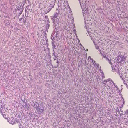

In [10]:
tf.keras.utils.load_img(benign_images[9], target_size=(size,size,1), grayscale=False)

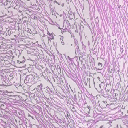

In [11]:
tf.keras.utils.load_img(malignent_images[45], target_size=(size,size,1), grayscale=False)

In [12]:
total_images = len(benign_images) + len(malignent_images)
total_images

7909

In [13]:
data = pd.DataFrame(index=np.arange(0, len(benign_images)+len(malignent_images)), columns=["image", "target"])
k=0
for c in [0,1]:
        if c==1:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 0
                k += 1
        else:
            for m in range(len(malignent_images)):
                data.iloc[k]["image"] = malignent_images[m]
                data.iloc[k]["target"] = 1
                k += 1
print(data.shape)
print(data.head())

(7909, 2)
                                               image target
0  ./augmented/malignant/SOB_M_DC-14-3909-40-010.png      1
1  ./augmented/malignant/SOB_M_LC-14-15570-100-05...      1
2  ./augmented/malignant/SOB_M_LC-14-12204-200-02...      1
3  ./augmented/malignant/SOB_M_DC-14-14015-100-02...      1
4  ./augmented/malignant/SOB_M_LC-14-15570C-400-0...      1


In [14]:
count_data = data["target"].value_counts()
count_data

target
1    5429
0    2480
Name: count, dtype: int64

In [15]:
ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

target
1    5429
0    5429
Name: count, dtype: int64

In [16]:
kf = KFold(n_splits=10,random_state=42, shuffle=True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [17]:
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size,size,1), grayscale=False)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
        
X = np.array(train_image)
y = up_sampled.iloc[:,-1].values
for train_index, test_index in kf.split(X,y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
                                       y[train_index], y[test_index]
    #print('train: %s, test: %s' % (X[train_index], X[test_index]))

for train_index, test_index in kf.split(X_test,y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], \
                                       y_test[train_index],y_test[test_index]
    
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y2_test, 2)
Y_val = np_utils.to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

100%|██████████| 10858/10858 [02:10<00:00, 83.29it/s]


(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


In [18]:
my_input= Input(shape=(size, size, 3))
img_shape= (size, size, 3)

In [19]:
data_gen = ImageDataGenerator(
        zoom_range=1.2,  # set range for random zoom
        rotation_range = 90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [20]:
data_gen.fit(X_train)
X_train.shape[0]

9773

In [21]:
data_gen.fit(X_val)
X_val.shape[0]

108

In [22]:
data_gen.fit(X2_test)
X2_test.shape[0]

977

# Model

In [23]:
#from keras.layers.advanced_activations import ELU
from keras.layers import ELU, PReLU, LeakyReLU,ThresholdedReLU

In [24]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [25]:
# bottleneck section 
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

In [26]:
def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('PReLU')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)

    return x


In [27]:
# Vision Transform Section
def vision_transform(inputs, patch_size):
    
    # Reshape the input into patches
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: K.cast(image, 'float32') / 255.0)(x)

    # architecture for each patch processing
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)
    
    return x

In [28]:
# overall model incorporating patches in the vision transform section and the neck section
def model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)

    # Merging the bottleneck, patches transform, and neck sections
    merged = tf.keras.layers.concatenate([efficientnet_bottleneck, patches_transform, neck])
    
    #bridge = Dense(64, activation='relu')(merged)
    
    outputs = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
input_shape = (size, size, 3)  # Example input shape
num_classes = 2  # number of classes
patch_size = (32, 32)   # Size of the image patches
batch_size = 64

In [30]:
with strategy.scope():
    model = model(input_shape, num_classes, patch_size)
    model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou,tversky]))

print(model.input_shape)
print(model.output_shape)
model.summary()  

24274472/24274472 [==============================] - 0s 0us/step
(None, 128, 128, 3)
(None, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 32, 32, 48)   0           ['input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 48)   0           ['reshape[0][0]']                
                                                                                                  

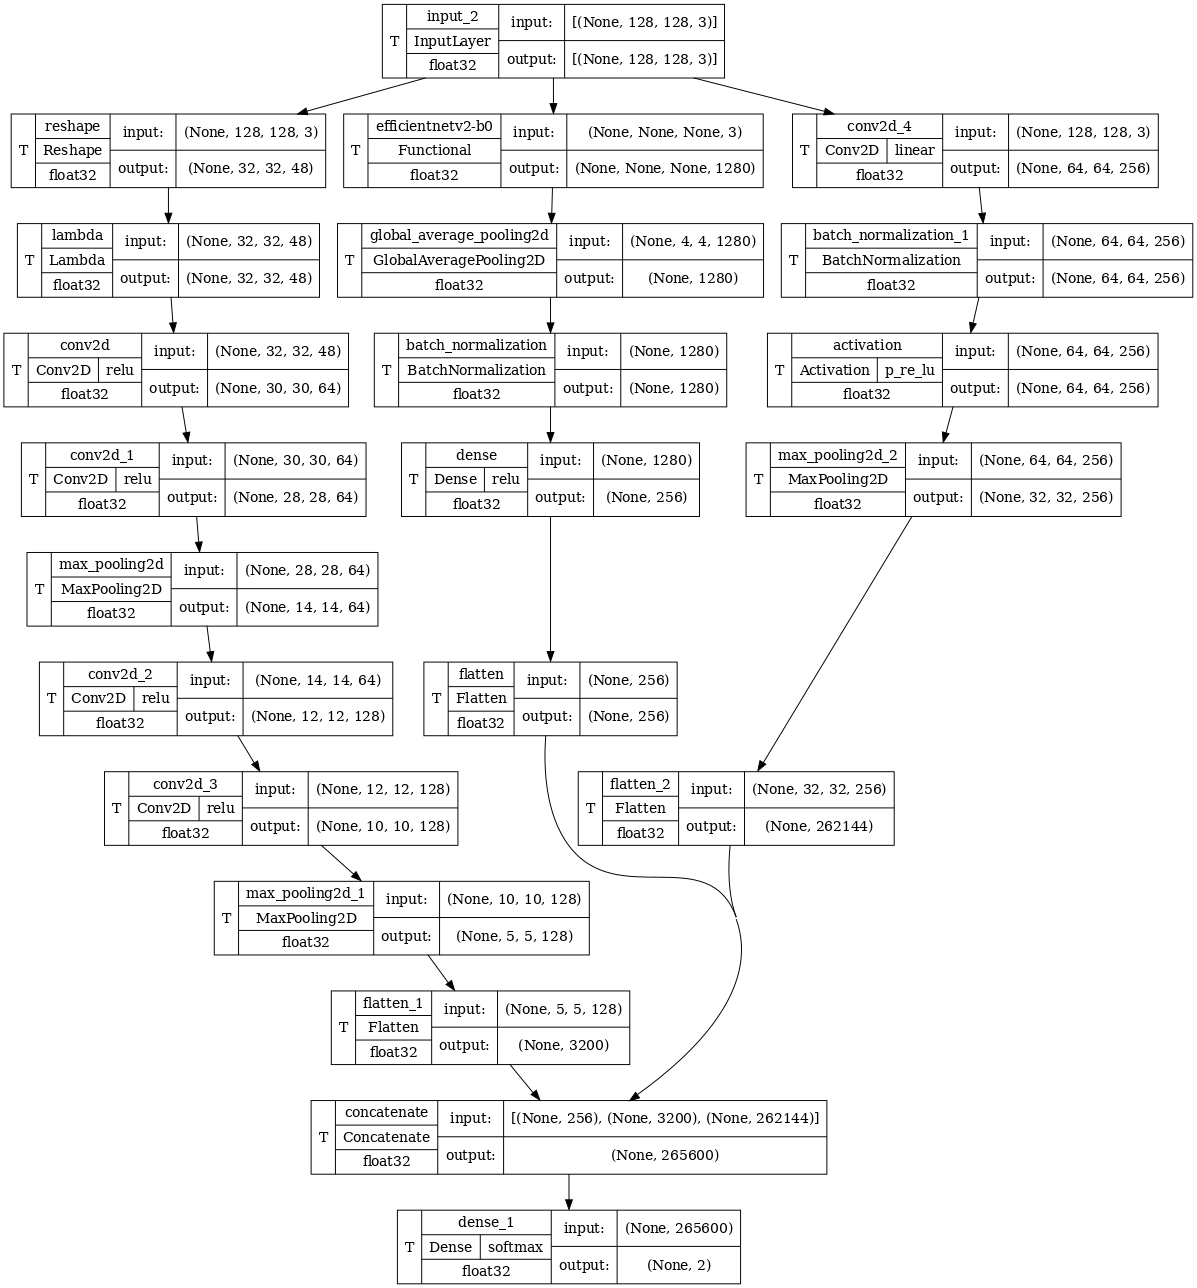

In [31]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
            show_trainable= True,
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [32]:
%%time
history = model.fit(data_gen.flow(X_train,Y_train,
                                       batch_size = batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks = callbacks,
                    epochs=50,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    validation_data =(data_gen.flow(X_val,Y_val,
                                       batch_size = batch_size, 
                                       seed=27,
                                       shuffle=True)))

Epoch 1/50


2023-11-04 09:07:00.304167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


152/152 [==============================] - 155s 352ms/step - loss: 6.7915 - accuracy: 0.7002 - precision: 0.7002 - recall: 0.7002 - AUC: 0.7228 - f1_score: 0.7003 - specificity: 0.7003 - sensitivity: 0.7003 - iou: 0.5528 - tversky: 0.7079 - val_loss: 1.0102 - val_accuracy: 0.5648 - val_precision: 0.5648 - val_recall: 0.5648 - val_AUC: 0.5790 - val_f1_score: 0.5689 - val_specificity: 0.5689 - val_sensitivity: 0.5689 - val_iou: 0.3858 - val_tversky: 0.5616 - lr: 0.0010
Epoch 2/50
152/152 [==============================] - 48s 314ms/step - loss: 2.6652 - accuracy: 0.7223 - precision: 0.7223 - recall: 0.7223 - AUC: 0.7647 - f1_score: 0.7222 - specificity: 0.7222 - sensitivity: 0.7222 - iou: 0.5760 - tversky: 0.7286 - val_loss: 0.9563 - val_accuracy: 0.6944 - val_precision: 0.6944 - val_recall: 0.6944 - val_AUC: 0.7492 - val_f1_score: 0.6960 - val_specificity: 0.6960 - val_sensitivity: 0.6960 - val_iou: 0.5208 - val_tversky: 0.6888 - lr: 0.0010
Epoch 3/50
152/152 [==========================

In [42]:
model.save("modelBH.h5")
print("Saved model to disk")

Saved model to disk


In [44]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
#df.to_csv("output1.csv")
df.head(50)

,loss,accuracy,precision,recall,AUC,f1_score,specificity,sensitivity,iou,tversky,...,val_accuracy,val_precision,val_recall,val_AUC,val_f1_score,val_specificity,val_sensitivity,val_iou,val_tversky,lr
0,6.791473,0.700175,0.700175,0.700175,0.722848,0.700319,0.700319,0.700319,0.552804,0.707909,...,0.564815,0.564815,0.564815,0.579047,0.568892,0.568892,0.568892,0.385750,0.561625,1.000000e-03
1,2.665192,0.722319,0.722319,0.722319,0.764692,0.722219,0.722219,0.722219,0.575986,0.728646,...,0.694444,0.694444,0.694444,0.749186,0.696023,0.696023,0.696023,0.520768,0.688771,1.000000e-03
2,2.418709,0.747142,0.747142,0.747142,0.792137,0.747027,0.747027,0.747027,0.609182,0.753917,...,0.592593,0.592593,0.592593,0.600223,0.595881,0.595881,0.595881,0.413942,0.591716,1.000000e-03
3,2.015099,0.766196,0.766196,0.766196,0.815858,0.766284,0.766284,0.766284,0.633613,0.772643,...,0.759259,0.759259,0.759259,0.796296,0.754261,0.754261,0.754261,0.604145,0.757513,1.000000e-03
4,1.201626,0.795448,0.795448,0.795448,0.852938,0.795419,0.795419,0.795419,0.663715,0.795834,...,0.731481,0.731481,0.731481,0.765861,0.730824,0.730824,0.730824,0.580116,0.735673,1.000000e-03
5,1.567214,0.791431,0.791431,0.791431,0.841341,0.791530,0.791530,0.791530,0.662370,0.794494,...,0.462963,0.462963,0.462963,0.462963,0.458097,0.458097,0.458097,0.306323,0.478261,1.000000e-03
6,1.433812,0.808322,0.808322,0.808322,0.857980,0.808308,0.808309,0.808309,0.682492,0.809062,...,0.537037,0.537037,0.537037,0.537037,0.541903,0.541903,0.541903,0.382419,0.558630,1.000000e-03
7,0.680253,0.835101,0.835101,0.835101,0.900264,0.835109,0.835109,0.835109,0.706130,0.826939,...,0.833333,0.833333,0.833333,0.836163,0.827415,0.827415,0.827415,0.663596,0.797574,2.000000e-04
8,0.449699,0.849109,0.849109,0.849109,0.920733,0.849270,0.849270,0.849270,0.715640,0.834042,...,0.750000,0.750000,0.750000,0.824331,0.735795,0.735795,0.735795,0.567582,0.724030,2.000000e-04
9,0.412741,0.855907,0.855907,0.855907,0.926578,0.856061,0.856061,0.856061,0.721530,0.838085,...,0.814815,0.814815,0.814815,0.921468,0.811790,0.811790,0.811790,0.691525,0.818349,2.000000e-04


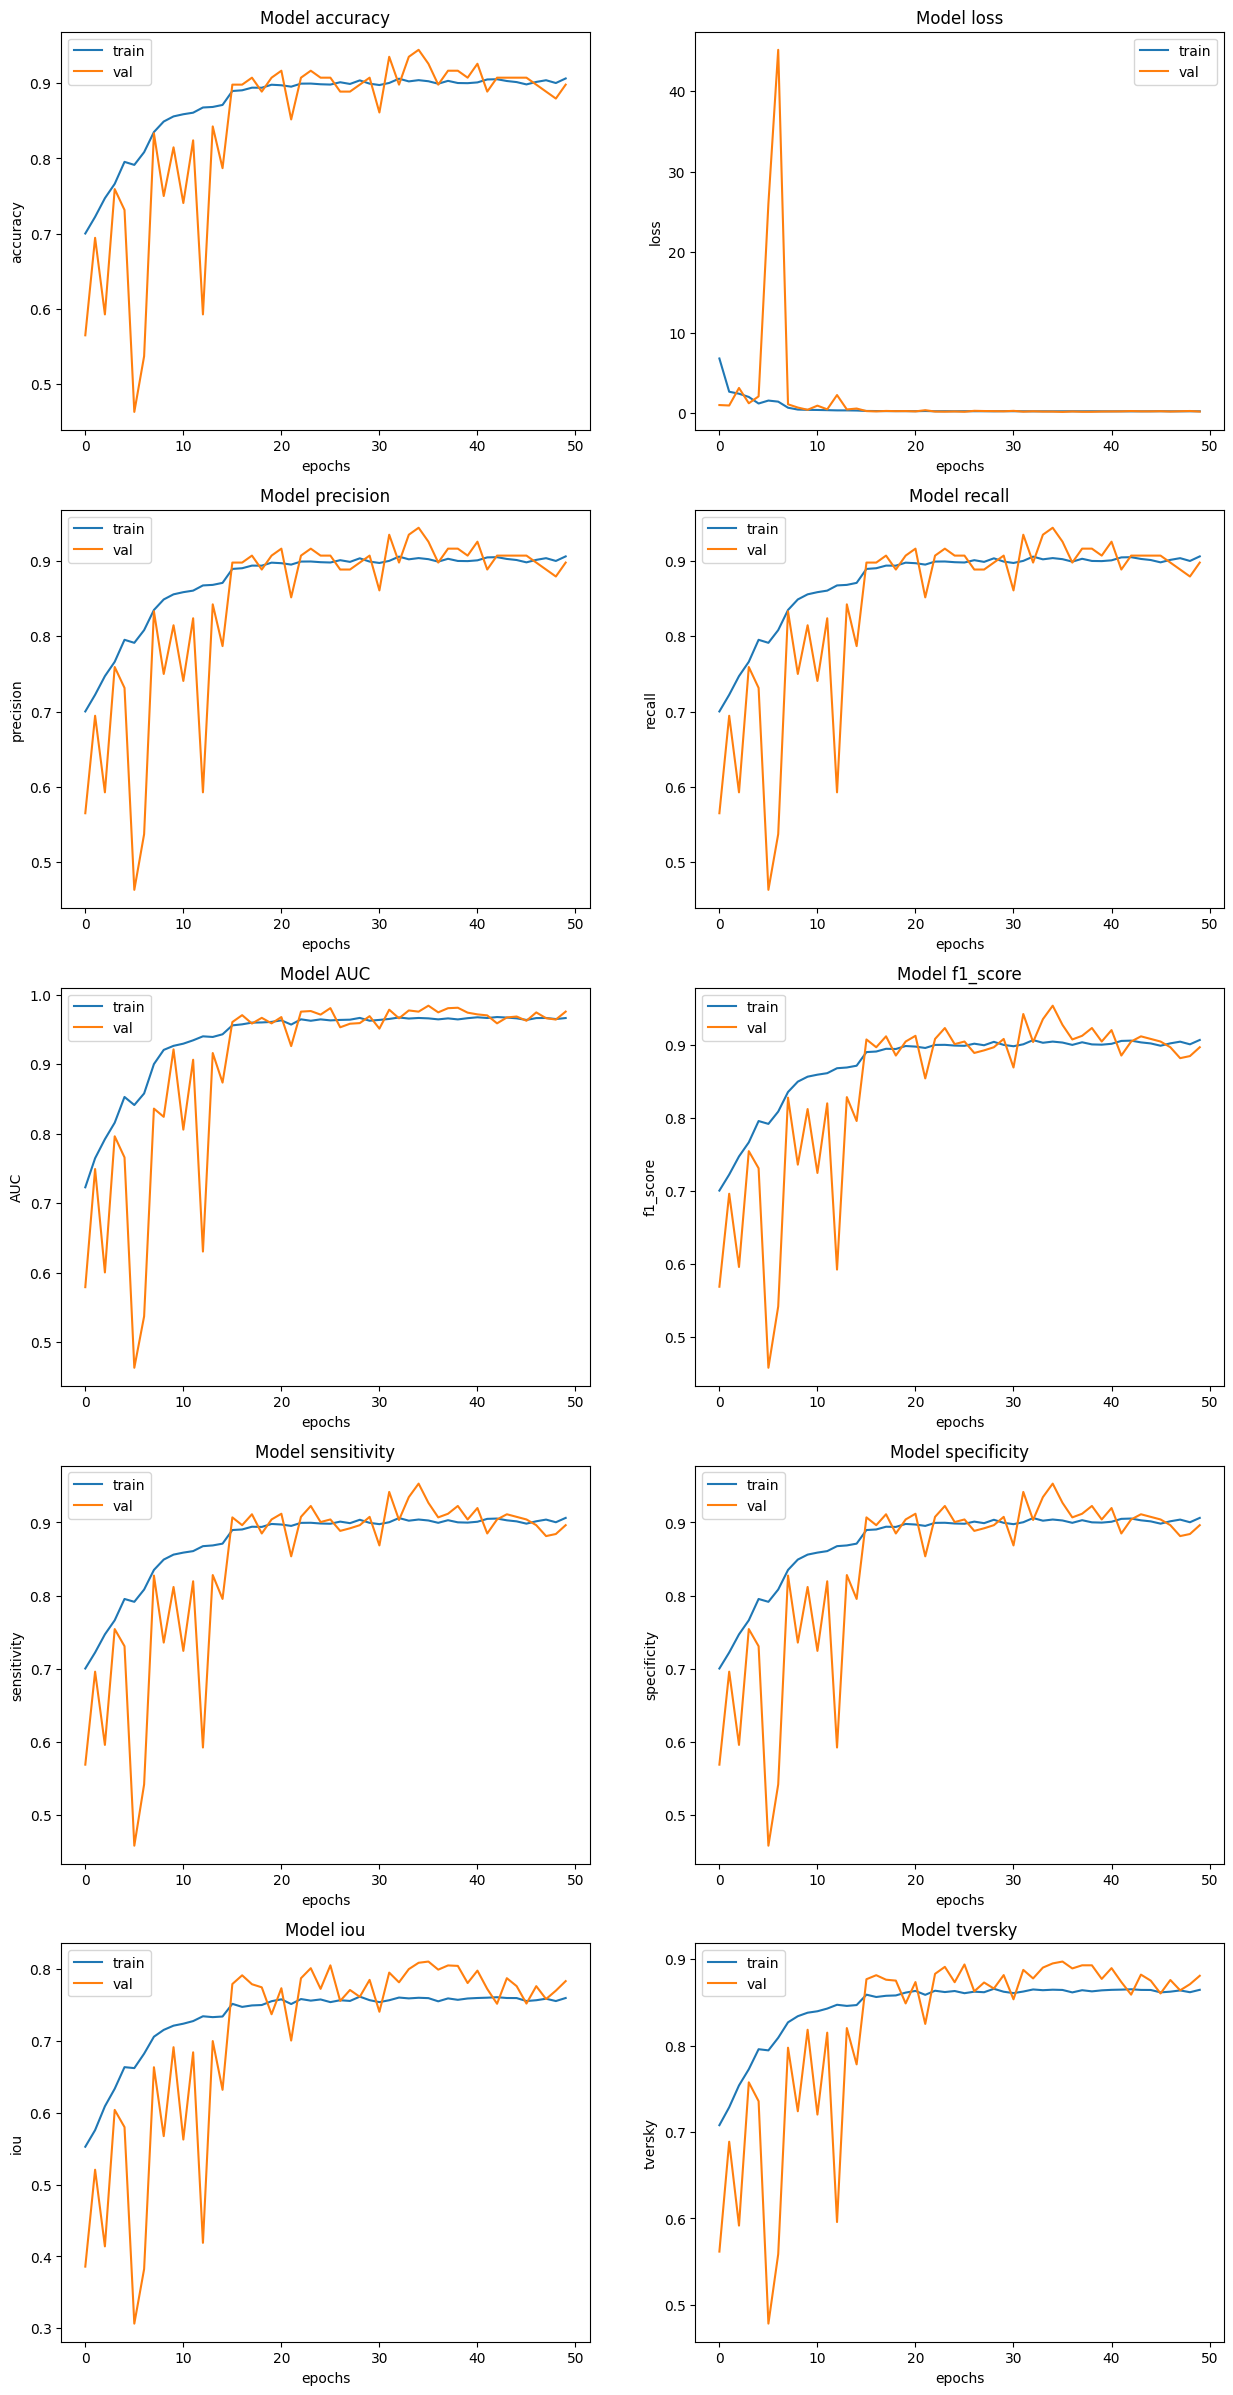

In [35]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

In [36]:
Test_data =(data_gen.flow(X2_test,Y_test,
                                       batch_size=128, 
                                       seed=27,
                                       shuffle=True))

In [37]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

Evaluate on test data
8/8 [==============================] - 6s 522ms/step - loss: 0.2269 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - AUC: 0.9683 - f1_score: 0.9052 - specificity: 0.9052 - sensitivity: 0.9052 - iou: 0.7659 - tversky: 0.8681
test loss test acc: [0.2269475758075714, 0.9048106670379639, 0.9048106670379639, 0.9048106670379639, 0.9683393239974976, 0.9051923751831055, 0.905192494392395, 0.905192494392395, 0.7659320831298828, 0.8680603504180908]
CPU times: user 10.4 s, sys: 286 ms, total: 10.7 s
Wall time: 6.37 s


In [38]:
truey=[]
predy=[]
x = X2_test
y = Y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

31/31 [==============================] - 7s 56ms/step
Predicted and true label values saved
Accuracy on test set :93.03991811668372%


[[465  33]
 [ 35 444]]


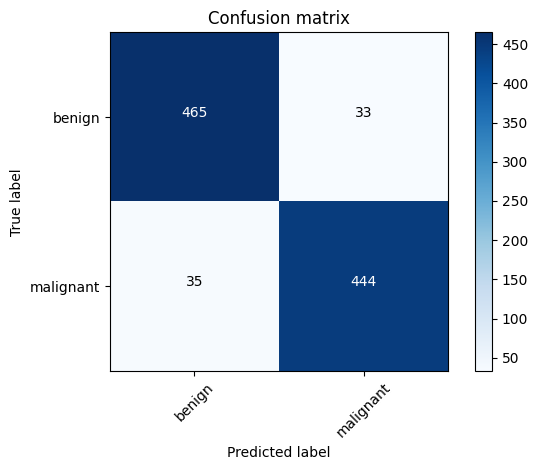

In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


confusion_matrix_img(truey, predy, savename='Confusion Matrix')

In [43]:
%%time
model0 = tf.keras.models.load_model('modelBH.h5',
                                           compile=False,
                                           custom_objects={
                                                'Accuracy': 'accuracy', 
                                                'Precision': tf.keras.metrics.Precision(), 
                                                'Recall': tf.keras.metrics.Recall(),
                                                'F1_Score': f1_score,})

model0.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss = "categorical_crossentropy")

CPU times: user 4.22 s, sys: 68.5 ms, total: 4.29 s
Wall time: 4.24 s
